In [1]:
import os
os.environ["JAX_CACHE_DIR"] = "/cluster/scratch/mpundir/jax-cache"
os.environ["JAX_PLATFORM"] = "cpu"

import jax

jax.config.update("jax_compilation_cache_dir", os.environ["JAX_CACHE_DIR"])
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_platforms", "cpu")

import sympy
import symfem

import numpy as np

import matplotlib.pyplot as plt

import itertools
import sys
sys.path.append('/cluster/home/mpundir/dev/femsolver')

from femsolver.plotting import color_scheme

from femsolver.fem_tools import (
    create_finite_element,
    compute_computational_nodes,
    create_basis,
    integrate_over_cell,
    interpolate_at_quadrature,
    batched_jacobian,
)

In [2]:
nodes = np.array([[0, 0], [0, 1.1], [1, 0], [1, 1]])
connectivity = np.array([0, 1, 2, 3])

In [86]:
degree = 1
element = create_finite_element(
    "quadrilateral", element_type="Lagrange", degree=degree, variant="equispaced"
)

In [87]:
@jax.tree_util.register_pytree_node_class
class Basis:
    """
    A class used to represent a Basis for finite element method (FEM) simulations.

    Attributes
    ----------
    N : jnp.ndarray
        Shape functions evaluated at quadrature points, with shape (nb_quads, nb_nodes_per_element).
    dNdξ : jnp.ndarray
        Derivatives of shape functions with respect to the reference coordinates, with shape (nb_quads, nb_nodes_per_element).
    wts : jnp.ndarray
        Quadrature weights, with shape (nb_quads).

    Methods
    -------
    tree_flatten():
        Flattens the Basis object into a tuple of children and auxiliary data for JAX transformations.
    tree_unflatten(aux_data, children):
        Reconstructs the Basis object from flattened children and auxiliary data.
    """

    def __init__(self, nb_quads, nb_nodes_per_element, dim=1):
        self.N = jnp.zeros((nb_quads, nb_nodes_per_element))
        self.dNdξ = jnp.zeros((dim, nb_quads, nb_nodes_per_element))
        self.d2Ndξ2 = jnp.zeros((dim, dim, nb_quads, nb_nodes_per_element))
        self.wts = jnp.zeros((dim, nb_quads))
        self.quad_pts = jnp.zeros((dim, nb_quads))

    def tree_flatten(self):
        return ((self.N, self.dNdξ, self.wts, self.quad_pts), None)

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        N, dNdξ, ω, quad_pts = children
        instance = cls(N.shape[0], N.shape[1])
        instance.N = N
        instance.dNdξ = dNdξ
        instance.wts = ω
        instance.quad_pts = quad_pts
        return instance


In [88]:
x, y = sympy.symbols("x y")

f = sympy.lambdify([x, y], element.get_basis_functions(), "jax")

# so that output is an array and not list
shape_fun = lambda x, y: jnp.array(f(x, y))

# using JAX JIT on the shape function
shape_functions = jax.jit(shape_fun)

# using forward-mode differentiation to compute the shape derivatives

shape_derivatives_x = jax.jit(jax.jacfwd(shape_functions, argnums=0))
shape_derivatives_y = jax.jit(jax.jacfwd(shape_functions, argnums=1))

# using forward-mode differentiation to compute the 2nd derivatives
shape_double_derivatives_xx = jax.jit(jax.jacfwd(shape_derivatives_x, argnums=0))
shape_double_derivatives_xy = jax.jit(jax.jacfwd(shape_derivatives_x, argnums=1))
shape_double_derivatives_yx = jax.jit(jax.jacfwd(shape_derivatives_y, argnums=0))
shape_double_derivatives_yy = jax.jit(jax.jacfwd(shape_derivatives_x, argnums=1))

# number of computational nodes (based on the polynomial degree)
nb_nodes = len(element.dof_plot_positions())

In [89]:
tdim = element.domain_dim
quadrature_rule = "legendre"
nb_quads = int(
    np.ceil((element.order + 1) / 2)
)  # for exact integration of polynomial degree

basis = Basis(nb_quads**tdim, nb_nodes, dim=tdim)

for i, quad in enumerate(
    list(
        itertools.product(
            symfem.quadrature.get_quadrature(quadrature_rule, nb_quads)[0], repeat=tdim
        )
    )
):

    basis.quad_pts = basis.quad_pts.at[0, i].set(float(quad[0]))
    basis.quad_pts = basis.quad_pts.at[1, i].set(float(quad[1]))
    
    basis.N = basis.N.at[i, :].set(shape_functions(float(quad[0]), float(quad[1])))

    basis.dNdξ = basis.dNdξ.at[0, i, :].set(
        shape_derivatives_x(float(quad[0]), float(quad[1]))
    )
    basis.dNdξ = basis.dNdξ.at[1, i, :].set(
        shape_derivatives_y(float(quad[0]), float(quad[1]))
    )

    basis.d2Ndξ2 = basis.d2Ndξ2.at[0, 0, i, :].set(
        shape_double_derivatives_xx(float(quad[0]), float(quad[1]))
    )
    basis.d2Ndξ2 = basis.d2Ndξ2.at[0, 1, i, :].set(
        shape_double_derivatives_xy(float(quad[0]), float(quad[1]))
    )
    basis.d2Ndξ2 = basis.d2Ndξ2.at[1, 0, i, :].set(
        shape_double_derivatives_yx(float(quad[0]), float(quad[1]))
    )
    basis.d2Ndξ2 = basis.d2Ndξ2.at[1, 1, i, :].set(
        shape_double_derivatives_yy(float(quad[0]), float(quad[1]))
    )


for i, wts in enumerate(
    list(
        itertools.product(
            symfem.quadrature.get_quadrature(quadrature_rule, nb_quads)[1], repeat=tdim
        )
    )
):   
    basis.wts = basis.wts.at[0, i].set(float(wts[0]))
    basis.wts = basis.wts.at[1, i].set(float(wts[1]))

In [90]:
basis.quad_pts

Array([[0.5],
       [0.5]], dtype=float64)

In [91]:
basis.wts

Array([[1.],
       [1.]], dtype=float64)

In [94]:
nodes[connectivity]

array([[0. , 0. ],
       [0. , 1.1],
       [1. , 0. ],
       [1. , 1. ]])

In [ ]:
@jax.jit
def map_to_quad_cell(x, cell_nodes):
    q11, q21, q22, q12 = cell_nodes[0], cell_nodes[1], cell_nodes[2], cell_nodes[3]
    mapped = jnp.zeros(2)
    mapped = mapped.at[0].set(linear_interpolation((x, v0, v1), 0))
    mapped = mapped.at[1].set(linear_interpolation((x, v0, v1), 1))
    return mapped


In [ ]:


# computing determinant of Jacobian for each cell
Js = batched_jacobian(0.5, nodes[connectivity])
tangents = batched_tangent(Js)
normals = batched_normal(tangents)
detJs = jnp.einsum("i..., i...->i", Js, tangents, optimize="optimal")

In [31]:
# defining dofs
dofs = np.zeros((total_comp_nodes, nb_dofs_per_node))

dofs[:, 0] = new_nodes[:, 0] ** 1
dofs[:, 1] = new_nodes[:, 0] ** 2

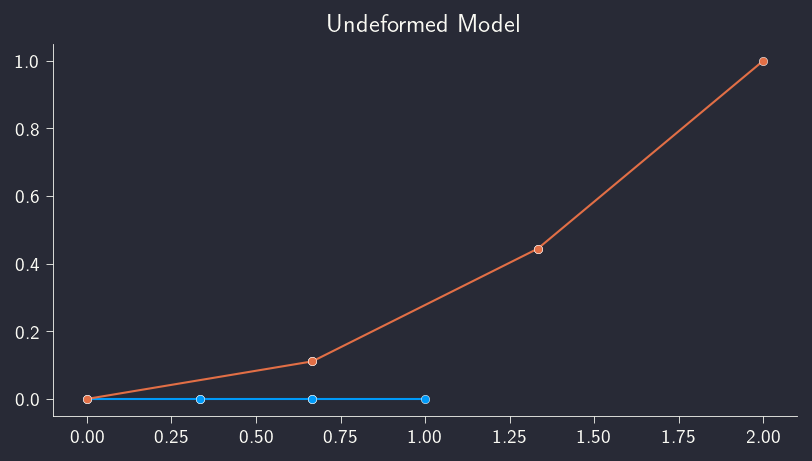

In [33]:
fig = plt.figure()
ax = plt.axes()

plot_lattice(ax=ax, nodes=new_nodes, connectivity=new_connectivity, degree=degree, color=color_scheme.blue)
plot_lattice(ax=ax, nodes=new_nodes+dofs, connectivity=new_connectivity, degree=degree, color=color_scheme.red)

ax.set_aspect("equal")
ax.set_title("Undeformed Model")
plt.show()

In [34]:
dofs = dofs.reshape(total_comp_nodes * nb_dofs_per_node, -1)

print(
    compute_axial_strain_energy(
        dofs, new_connectivity, detJs, Js, tangents, basis.wts, basis.dNdξ
    )
)

print(
    compute_bending_strain_energy(
        dofs, new_connectivity, detJs, Js, tangents, normals, basis.wts, basis.d2Ndξ2
    )
)

0.49999999999999994
0.020000000000000004


In [35]:
@jax.jit
def compute_strain_energy(
    dofs, new_connectivity, detJs, Js, tangents, normals, wts, dNdξ, d2Ndξ2
):
    return compute_axial_strain_energy(
        dofs, new_connectivity, detJs, Js, tangents, wts, dNdξ
    ) + compute_bending_strain_energy(
        dofs, new_connectivity, detJs, Js, tangents, normals, wts, d2Ndξ2
    )

In [36]:
compute_internal_force = jax.jit(jax.jacrev(compute_strain_energy))

In [37]:
residual = compute_internal_force(
    dofs,
    new_connectivity,
    detJs,
    Js,
    tangents,
    normals,
    basis.wts,
    basis.dNdξ,
    basis.d2Ndξ2,
)

## functions to get the global dofs

In [14]:
def get_global_dofs_x(nodes, x, ndofs=2):
    idx = np.where(np.isclose(nodes[:, 0], x, atol=1e-8) == True)[0]
    return idx * ndofs, idx * ndofs + 1

In [15]:
def get_global_dofs_y(nodes, y, ndofs=2):
    idx = np.where(np.isclose(nodes[:, 1], y, atol=1e-8)== True )[0]
    return (idx * ndofs, idx * ndofs + 1)

In [16]:
right_dofs = get_global_dofs_x(nodes=new_nodes, x=np.max(new_nodes[:, 0]))
left_dofs = get_global_dofs_x(nodes=new_nodes, x=np.min(new_nodes[:, 0]))

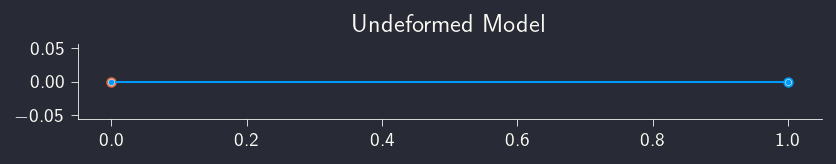

In [17]:
fig, ax = plt.subplots()

for item in new_connectivity:
    n1 = new_nodes[item[0]]  # Note: Python uses 0-based indexing
    n2 = new_nodes[item[1]]
    ax.plot([n1[0], n2[0]], [n1[1], n2[1]], markersize=3,  marker='o',color=color_scheme.blue)
ax.scatter(x=new_nodes.reshape(-1)[right_dofs[0]], y=new_nodes.reshape(-1)[right_dofs[1]])
ax.scatter(x=new_nodes.reshape(-1)[left_dofs[0]], y=new_nodes.reshape(-1)[left_dofs[1]])

ax.set_aspect("equal")
ax.set_title("Undeformed Model")
plt.show()

## applying the BC

In [18]:
def apply_boundary_conditions(u):
    applied_displacement = 0.5
    u = u.at[right_dofs[1]].set(applied_displacement)
    u = u.at[right_dofs[0]].set(0)
    u = u.at[left_dofs[0]].set(0.0)
    u = u.at[left_dofs[1]].set(0.0)
    return u

def apply_boundary_conditions_to_residual(res):
    res = res.at[right_dofs[0]].set(0.0)
    res = res.at[right_dofs[1]].set(0.0)
    res = res.at[left_dofs[0]].set(0.0)
    res = res.at[left_dofs[1]].set(0.0)
    return res
    

In [19]:
u = jnp.zeros((total_comp_nodes, nb_dofs_per_node))
u = u.reshape(total_comp_nodes * nb_dofs_per_node, -1)

u = apply_boundary_conditions(u)

u_prev = jnp.zeros(total_comp_nodes * nb_dofs_per_node)

In [20]:
u

Array([[0. ],
       [0. ],
       [0. ],
       [0.5],
       [0. ],
       [0. ],
       [0. ],
       [0. ]], dtype=float64)

## defining gradient descent

In [21]:
def gradient_descent_cache(
    dofs,
    new_connectivity,
    detJs,
    Js,
    tangents,
    normals,
    wts,
    dNdξ,
    d2Ndξ2,
    learning_rate=0.001,
    num_iterations=1000,
):

    iterations = jnp.arange(num_iterations)
    _, (positions_over_time, loss_over_time) = jax.lax.scan(
        grad_step_with_time_evolution,
        (
            dofs,
            new_connectivity,
            detJs,
            Js,
            tangents,
            normals,
            wts,
            dNdξ,
            d2Ndξ2,
            learning_rate,
        ),
        iterations,
    )

    return positions_over_time, loss_over_time


def grad_step_with_time_evolution(carry, _):
    (
        dofs,
        new_connectivity,
        detJs,
        Js,
        tangents,
        normals,
        wts,
        dNdξ,
        d2Ndξ2,
        learning_rate,
    ) = carry
    loss_val = compute_strain_energy(
        dofs,
        new_connectivity,
        detJs,
        Js,
        tangents,
        normals,
        wts,
        dNdξ,
        d2Ndξ2,
    )
    grad = compute_internal_force(
        dofs,
        new_connectivity,
        detJs,
        Js,
        tangents,
        normals,
        wts,
        dNdξ,
        d2Ndξ2,
    )
    dofs -= learning_rate * grad
    dofs = apply_boundary_conditions(dofs)

    return (
        dofs,
        new_connectivity,
        detJs,
        Js,
        tangents,
        normals,
        wts,
        dNdξ,
        d2Ndξ2,
        learning_rate,
    ), (dofs, loss_val)

## solving 

In [22]:
uu, xx = gradient_descent_cache(
    u,
    new_connectivity,
    detJs,
    Js,
    tangents,
    normals,
    basis.wts,
    basis.dNdξ,
    basis.d2Ndξ2,
    learning_rate=0.02,
    num_iterations=1000,
)

In [23]:
uu[-1, :]

Array([[0.        ],
       [0.        ],
       [0.        ],
       [0.5       ],
       [0.        ],
       [0.16659324],
       [0.        ],
       [0.33325991]], dtype=float64)

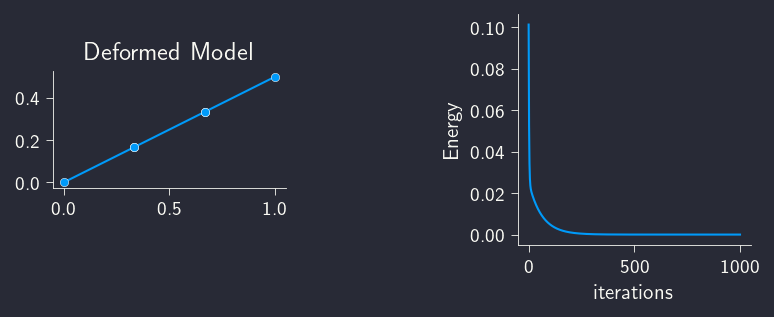

In [24]:
u_final =uu[-1, :].reshape(-1, 2)

fig, axes = plt.subplots(1, 2, figsize=(6, 2), gridspec_kw={"wspace": 1})
ax = axes[0]
plot_lattice(
    ax=ax,
    nodes=new_nodes + u_final,
    connectivity=new_connectivity,
    degree=degree,
    color=color_scheme.blue,
)
ax.set_aspect("equal")
ax.set_title("Deformed Model")

ax = axes[1]
ax.plot(xx)
ax.set_xlabel("iterations")
ax.set_ylabel("Energy")
plt.show()